In [1]:
import os
from PIL import Image
import util.image_import as ii
from glob import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.applications import mobilenet
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from util.plots import plot_history
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Trick to configure gpu memory dynamically

In [2]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Subtracting mean and normalizing to save pictures

In [3]:
# Importing the images
images_train = []
images_test = []

images_train.append(glob(os.path.join("../dataset3/res_still/train/arm", "*.jpg")))
images_train.append(glob(os.path.join("../dataset3/res_still/train/background", "*.jpg")))
images_train.append(glob(os.path.join("../dataset3/res_still/train/bun", "*.jpg")))
images_train.append(glob(os.path.join("../dataset3/res_still/train/carrots", "*.jpg")))
images_train.append(glob(os.path.join("../dataset3/res_still/train/catfood_beef", "*.jpg")))
#images_train.append(glob(os.path.join("../dataset3/res_still/train/catfood_salmon", "*.jpg")))
images_train.append(glob(os.path.join("../dataset3/res_still/train/ketchup", "*.jpg")))
images_train.append(glob(os.path.join("../dataset3/res_still/train/potato", "*.jpg")))

images_test.append(glob(os.path.join("../dataset3/res_still/test/arm", "*.jpg")))
images_test.append(glob(os.path.join("../dataset3/res_still/test/background", "*.jpg")))
images_test.append(glob(os.path.join("../dataset3/res_still/test/bun", "*.jpg")))
images_test.append(glob(os.path.join("../dataset3/res_still/train/carrots", "*.jpg")))
images_test.append(glob(os.path.join("../dataset3/res_still/test/catfood_beef", "*.jpg")))
#images_test.append(glob(os.path.join("../dataset3/res_still/test/catfood_salmon", "*.jpg")))
images_test.append(glob(os.path.join("../dataset3/res_still/test/ketchup", "*.jpg")))
images_test.append(glob(os.path.join("../dataset3/res_still/test/potato", "*.jpg")))
    

X_train, y_train = ii.images_to_numpy_full_class(images_train)
X_test, y_test = ii.images_to_numpy_full_class(images_test)

print("Number of training images: " + str(X_train.shape[0]) + " Number of test images: " + str(X_test.shape[0]))

# Setup of image data generator
batch_size = 32
num_classes = 7

# Making datagen for training with normilization, center, and dataugmentation
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35)
)

# Making datagen for validation and test with normilization
test_datagen = ImageDataGenerator(
        featurewise_center=True, 
        featurewise_std_normalization=True,
        rescale=1./255
)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Required for featurewise normalization
train_datagen.fit(X_train/.255)
test_datagen.fit(X_train/.255)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)

test_generator = test_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)


Number of training images: 1633 Number of test images: 519


## Optimized model single run <span style="color:red"> Not done</span>

In [4]:
model_optimized = Sequential()
model_optimized.add(Flatten(input_shape=(224,224,3)))
model_optimized.add(Dense(256))
model_optimized.add(Activation('relu'))
model_optimized.add(Dense(7))
model_optimized.add(Activation('softmax'))
model_optimized.compile(loss='categorical_crossentropy',
                        optimizer=Adam(lr=1e-4),
                        metrics=['accuracy'])

model_optimized.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38535424  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
_________________________________________________________________
activation_2 (Activation)    (None, 7)                 0         
Total params: 38,537,223
Trainable params: 38,537,223
Non-trainable params: 0
_________________________________________________________________


In [5]:
history_optimized = model_optimized.fit_generator(
                    train_generator,
                    steps_per_epoch=1641 // batch_size,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=521 // batch_size)


Epoch 1/100
51/51 [==============================] - 16s 306ms/step - loss: 13.3447 - acc: 0.1440 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 2/100
51/51 [==============================] - 15s 300ms/step - loss: 13.7765 - acc: 0.1453 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 3/100
51/51 [==============================] - 15s 294ms/step - loss: 13.9050 - acc: 0.1373 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 4/100
51/51 [==============================] - 15s 299ms/step - loss: 13.7864 - acc: 0.1447 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 5/100
51/51 [==============================] - 15s 295ms/step - loss: 13.5454 - acc: 0.1596 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 6/100
51/51 [==============================] - 15s 300ms/step - loss: 13.8070 - acc: 0.1434 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 7/100
51/51 [==============================] - 16s 305ms/step - loss: 13.8053 - acc: 0.1435 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 8/100
51/51 [=============================

Epoch 61/100
51/51 [==============================] - 15s 295ms/step - loss: 13.4960 - acc: 0.1627 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 62/100
51/51 [==============================] - 15s 299ms/step - loss: 13.8358 - acc: 0.1416 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 63/100
51/51 [==============================] - 15s 297ms/step - loss: 13.8852 - acc: 0.1385 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 64/100
51/51 [==============================] - 15s 297ms/step - loss: 13.7568 - acc: 0.1465 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 65/100
51/51 [==============================] - 16s 314ms/step - loss: 13.8762 - acc: 0.1391 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 66/100
51/51 [==============================] - 15s 304ms/step - loss: 13.8062 - acc: 0.1434 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 67/100
51/51 [==============================] - 15s 299ms/step - loss: 13.7864 - acc: 0.1447 - val_loss: 13.5367 - val_acc: 0.1602
Epoch 68/100
51/51 [=====================

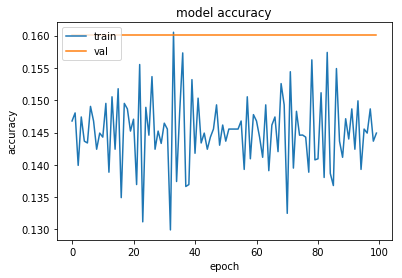

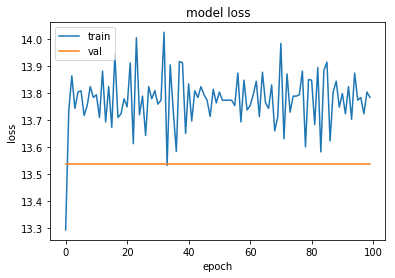

In [6]:
plot_history(history_optimized, save=True, path='nets/feedforward/', name='plot_full')

In [10]:
imgs, labels = next(test_generator)

#ynew = model.predict(imgs)
#results[(lr, lrd, rs, hl)] = (y_train_acc, y_pred_acc)

model_optimized.evaluate(imgs,labels, batch_size=80)

80/80 [==============================] - 0s 638us/step


[0.039275094866752625, 0.987500011920929]

In [ ]:
imgs, labels = next(validation_generator)
history_optimized.predict(imgs)